# Time Series Analysis, Part II

**Goal:** Find outliers, trends and periodicity in the MTA turnstyle data    

**Data:**
* **MTA subway fares**: It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.
* *The data was organized  by Sina Kashuk at CUSP.*
* *It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows*

**Outline**
* **Task 4:**
    * Several stations show a prominent annual periodicity. **Identify the 4 stations** (identify them by the index of their location in the data cube) **that show the most prominent periodic trend on an annual period (52 weeks)**. *Can you figure out what the periodic peak in rides is due to?*
    
* **Task 5: Extra Credit**
    * Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:
        - are there distinct clusters?
        - do they reflect the card type or station? 
    * To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: 
    * subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation
        * feature = (feature - feature.mean() ) / feature.std()
    * each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)
    * Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead: 
        * observation = (observation -observation.mean()) / observation.std()
        * each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

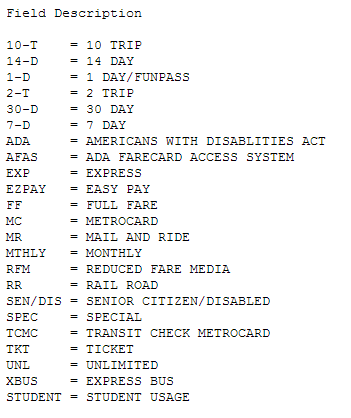

In [1]:
from __future__ import print_function, division
import matplotlib.pylab as pl
import numpy as np
import pandas as pd

# from sklearn.ensemble  import RandomForestClassifier as rfc
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

## Data Ingestion

In [2]:
# Load initial data and report shape
mta = np.load("./pMTA_Fare.npy")
mta = mta.astype('float')
mta[mta == -1] = np.nan

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [5]:
# Date Range
daterange = pd.date_range(start='2010-05-21', 
                          freq='W-FRI', periods=194)

(0, 194)

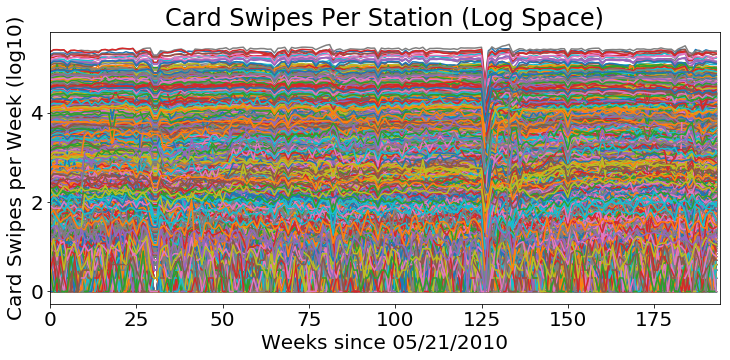

In [10]:
# Log Space all stations, all card types
pl.figure(figsize=(12,5))

for x in mta: 
    for y in x:
        plotme = pd.DataFrame(y,columns=['sum'])
        plotme.reset_index(inplace=True)
        pl.plot(plotme['index'],np.log10(plotme['sum']))

pl.title('Card Swipes Per Station (Log Space)')
pl.ylabel('Card Swipes per Week (log10)')
pl.xlabel('Weeks since 05/21/2010')
pl.xlim(0,194)

**Figure 1:** Time Series for all ride types and all stations in semi-log space.

## Task 4: Periodicity Detection / Fourier Transform

The following will use numpy function *np.fft.rfft()* to take the fourier transform, and *np.fft.rfftfreq()* (frequency function) to create a meaningful x axis. We can divide 1 by our frequency to get periodicity ($1/f =$ periodicity)

In [102]:
# sum to one time series
timeSeries = np.nansum(mta,axis=(1))
timeSeries.shape

(600, 194)

(3.8, 5.8)

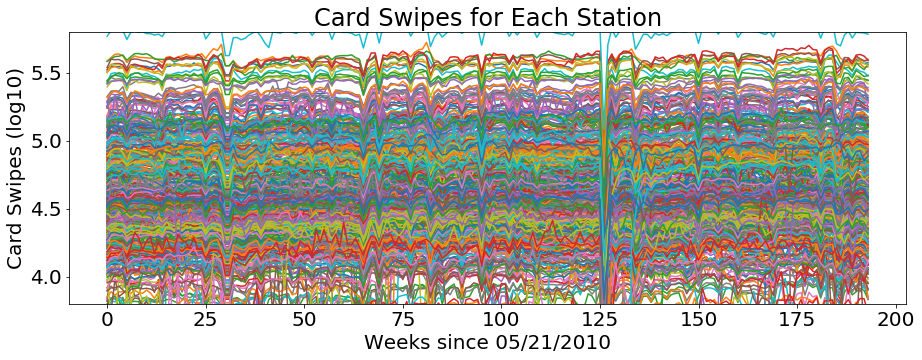

In [109]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(600):
    ax.plot(range(194),np.log10(timeSeries[i]))
pl.xlabel('Weeks since 05/21/2010')
pl.ylabel('Card Swipes (log10)')
pl.title('Card Swipes for Each Station')
pl.ylim(3.8,5.8)

**Figure 2:** Card Swipes for every station (sum of all card types) plotted in semi-log space. Notice these are contained in a smaller range than Figure 1.

In [177]:
N = 3*52 #since we had over 3 years, this shorten it
f = np.fft.rfft(timeSeries, n=N ).real**2

Text(0.5,1,'Power Spectrum of Every Station')

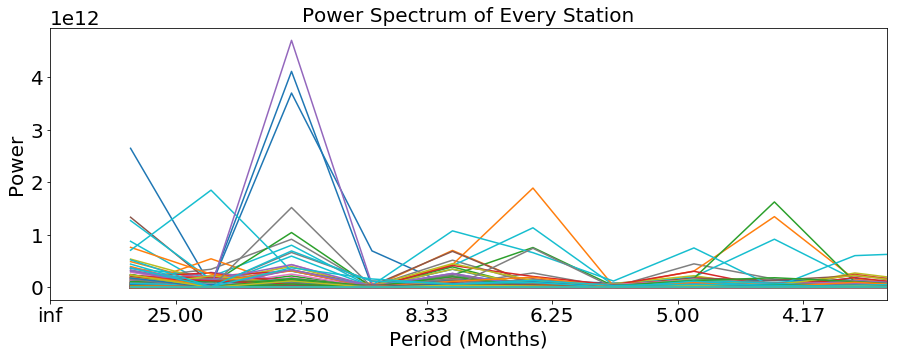

In [195]:
fig = pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(600):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(f[i][1:]), '-')    

# changing the labels on the x ticks to see the period instead of frequency
ax.set_xlim(0,1.0/15) 
ax.set_xticklabels([ "%.2f"%(1/4./z) for z in ax.get_xticks()], fontsize=20) #months defined as intervals of 4 weeks
pl.xlabel("Period (Months)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title ("Power Spectrum of Every Station",fontsize=20)

**Figure 3:** Notice there are 3 stations that have a much higher annual periodicity than the rest. There is also a fourth in green. These are grouped slightly more than 12 months because we are defining months as 4 weeks (not exact)

**But how do we get the index of the top 4 stations?**

In [189]:
# Thanks to Pablo for showing me how the power spectrum is sorted
1/np.fft.rfftfreq(N, 1.0) #this represents the periodicity, the third index is the one we want (52 weeks)

array([          inf,  156.        ,   78.        ,   52.        ,
         39.        ,   31.2       ,   26.        ,   22.28571429,
         19.5       ,   17.33333333,   15.6       ,   14.18181818,
         13.        ,   12.        ,   11.14285714,   10.4       ,
          9.75      ,    9.17647059,    8.66666667,    8.21052632,
          7.8       ,    7.42857143,    7.09090909,    6.7826087 ,
          6.5       ,    6.24      ,    6.        ,    5.77777778,
          5.57142857,    5.37931034,    5.2       ,    5.03225806,
          4.875     ,    4.72727273,    4.58823529,    4.45714286,
          4.33333333,    4.21621622,    4.10526316,    4.        ,
          3.9       ,    3.80487805,    3.71428571,    3.62790698,
          3.54545455,    3.46666667,    3.39130435,    3.31914894,
          3.25      ,    3.18367347,    3.12      ,    3.05882353,
          3.        ,    2.94339623,    2.88888889,    2.83636364,
          2.78571429,    2.73684211,    2.68965517,    2.64406

In [186]:
#What are the top power levels for a 52 week period?
find = np.argsort(-f[:,3]) #plot above shows 52 weeks at 3d index
find[:4]

array([194, 150,   0, 327])

(-0.018269230769230774, 0.5246794871794872)

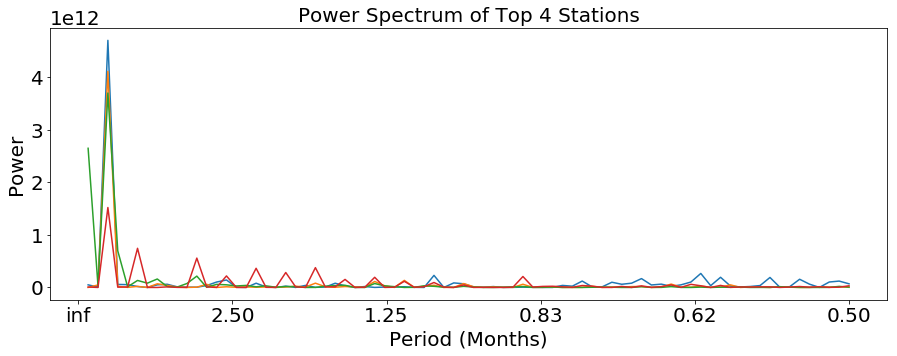

In [199]:
fig = pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(4):
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(f[find[i]][1:]), '-')
    
ax.set_xticklabels([ "%.2f"%(1/4./z) for z in ax.get_xticks()], fontsize=20) #MONTHS
pl.xlabel("Period (Months)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title ("Power Spectrum of Top 4 Stations",fontsize=20)
pl.xlim()

**Figure 4**: Here are the top 4 stations **(194, 150, 0, & 327)** fourier transformations plotted  over their frequency. Notice the significant peaks right around the 12 month period. 

## Interpretation
It intuitively makes sense that subway stations have an annual periodicity in their time series. Ridership levels vary depending on season (e.g. more people during winter vs summer) and the repetition of annual holidays probably has a significant impact as well. However, I am not certain why periodicity in these 4 stations is so much more prevalent. There is nothing in the data that can help us ID them.